# Example 2 - 3D network in simple geology

This is the second notebook in a series aiming at introducing pyKasso.

In this notebook we show how to create a 3D Discrete Karst Network assuming a simple conceptual geological model with a flat topography on top, an inclined karstifiable layer, and a horizontal groundwater surface separating the vadose from the phreatic zone.

The aim of this notebook is to demonstrate how one can build a simple 3D geological model using standard numpy methods. It demonstrates the use of the anisotropic fast marching in 3D. 

This notebook is accompanying the paper cited below.

**Reference**: Miville, F., Renard, P., Fandel, C., Filipponi, M. 2025: pyKasso: An open-source three-dimensional discrete karst network generator. Environmental Modelling & Software, Volume 186, https://doi.org/10.1016/j.envsoft.2025.106362

© 2025 *François Miville, Chloé Fandel and Philippe Renard - University of Neuchâtel / Carleton College*

## 1. Initialization

The first step consists in importing the pykasso and numpy packages, and creating the pykasso application. 

Then, the dimension of the grid covering the domain of interest must be defined, and the project is created using the pykasso application.

When this is done, pykasso creates a subdirectory in the current folder. This new folder has the same name as the project name and will contain all the model parameters, the logs, and the outputs.

Finally, we also set a few options for the visualization.

In [1]:
# Import the pyKasso and numpy packages
import pykasso as pk
import numpy as np
import os

# Create a pyKasso application
app = pk.pykasso()

# Declare the grid parameters
grid_parameters = {
    'x0': 0, 'y0': 0, 'z0': 0,
    'nx': 100, 'ny': 100, 'nz': 50,
    'dx': 10, 'dy': 10, 'dz': 10,
}

# Declare the project parameters
app.new_project(name='example_02', grid_parameters=grid_parameters)

# Declare some options for the visualization
app.visualizer.notebook = True
extent = app.project.grid.extent
imshow_options = {'extent': extent}

## 2. Generating the 3D geology

The geological model is very simple, it includes only two layers. In the upper part of the domain, there is a limestone formation.  Below, there is a non karstifiable basement formation that we call bedrock. The top of the bedrock is inclined. 

To build the 3D model, we only need to provide the surface describing the elevation of the top of the bedrock. The aim of the following code-block is to generate that surface.

The surface that has the same horizontal extension as the 3D grid. The altitude of the surface decreases from 300 m on the west side to 100 m on the east side (along the $x$ axis). To generate it, we first create a vector of values ranging from 300 to 100, and then we repeat this vector along the $y$ axis to fill a numpy array that has the same extension as the 3D grid. We then plot the surface to check it.

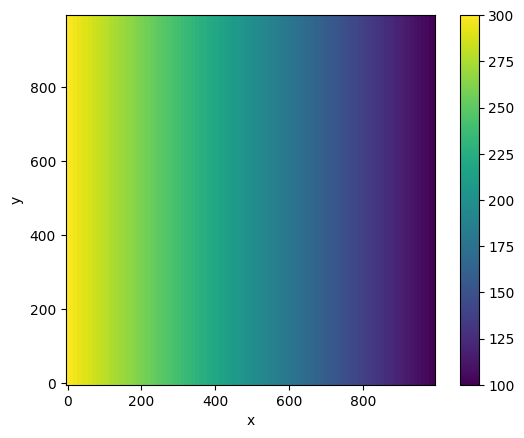

In [2]:
bedrock = np.linspace(300, 100, grid_parameters['nx'])
bedrock = np.repeat(bedrock[:, np.newaxis], grid_parameters['ny'], axis=1)
app.visualizer.mpl_plot_array_2D(bedrock, imshow_options=imshow_options, show_colorbar=True);

## 3. Generating the water table

The water table surface will be used to separate the vadose zone in the upper part of the 3D model from the phreatic zone in the lower part of the domain.

In the vadose zone, the conduits are supposed to be mainly controlled by gravity and will therefore be mainly oriented vertically or following the bedding of impervious surfaces at the bottom of the karstifiable formation. In the phreatic zone, the conduits may have any orientation.

In the code-block below, to define the water table, we just create a 2D grid having the same dimension as the horizontal dimension of the 3D grid. And we fill the grid with a unique value: the altitude of the groundwater level (200 m). In more complex situation, we may have some information about the altitude of this surface and generate a more realistic map. But for the simple example of this notebook, we will only use this constant value.

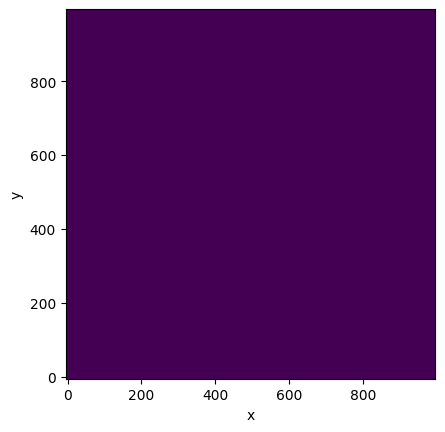

In [3]:
grid_shape = app.project.grid.shape[:2]
water_table = np.full(grid_shape, 200)
app.visualizer.mpl_plot_array_2D(water_table, imshow_options=imshow_options);

## 4.  Setting the model parameters

For this example, we define the master seed for the random number generator used in pyKasso. The master seed is set within the `sks` dictionary. When it is given, the master seed controls the generation of all the random features such as the location of inlets and outlets, the fractures, etc. We can also define specific seeds for specific random processes. We illustrate this for the `outlets` and `inlets` in the code below.

We the simulation domain and provide the two arrays that we created previously for the top of the bedrock and for the groundwater level.

We then define one outlet at a random position located within the phreatic part above the top of the bedrock. For the inlets, we indicate that there are 10 random inlets.

In [4]:
# Declare the model parameters
model_parameters = {
    'sks' : {
        'seed' : 1,
    },
    'domain' : {
        'bedrock' : bedrock,
        'water_table' : water_table
    },
    'outlets' : {
        'seed' : 1,
        'number' : 1,
        'subdomain': 'bedrock_phreatic',
    },
    'inlets' : {
        'seed' : 1,
        'number': 10,
    }
}

## 5. Generating the karst network simulations

We run two simulations to show the impact of using an isotropic or anisotropic fast marching algorithm. 

The two simulations have exactly the same input parameters, the only difference is the use of an anisotropic fast marching technique when we select the `Riemann3` option for the algorithm of `sks`. 

In [5]:
# Compute 1 simulation with isotropic and 1 simulation with anisotropic fast marching algortihm
for algorithm in ['Isotropic3', 'Riemann3']:
    model_parameters['sks']['algorithm'] = algorithm
    app.model.generate(model_parameters=model_parameters)

## 6. 3D plots of the results

To compare the results of the two simulation, we will plot in 3D the networks that we obtained with both options. 

The 3D plotting relies on the pyvista package. To access those functionalities, one has to define the settings for generating a plot and launch the `visualizer.pv_show()` method. 

The resulting figure shows that if one uses the Isotropic fast marching approach, all the conduits go straight from the inlets to the outlet. If we activate the `Riemann3` option, the fast marching becomes anisotropic and the conduits follow mainly a vertical direction in the vadose zone, unless they reach the top of the bedrock. In that case they follow the slope of the top of the bedrock. In the phreatic part, the conduits go directly to the outlets.


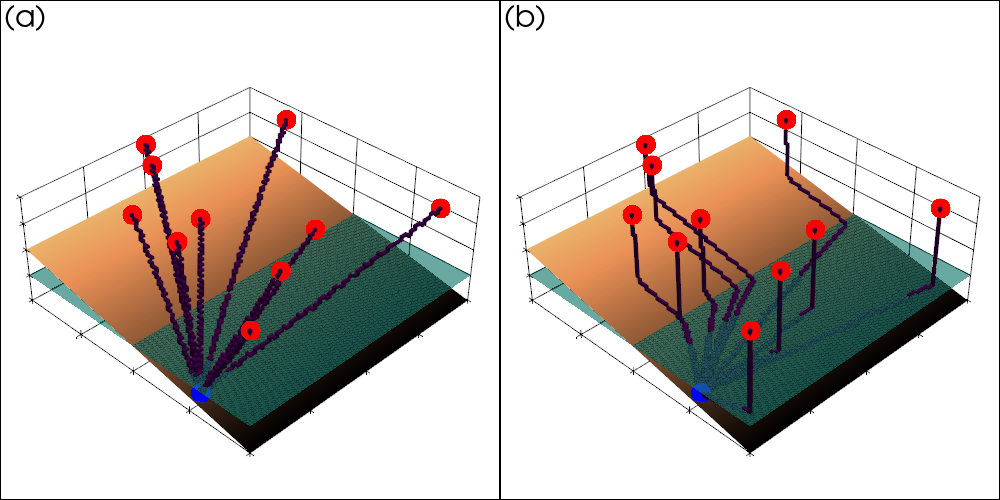

In [6]:
# Basic settings for pv_show() 
settings = {
    'mask_values': [0], # To mask the geology
    'surfaces_options' : { # To see the top bedrock and water level
        'bedrock' : {'opacity':1, 'cmap': 'copper'},
        'water_table' : {},
    },
    'inlets_options' : {},
    'outlets_options' : {},
    'show_scalar_bar' : False,
}

# To add the (a) and (b) labels on the subfigures
font_size = 12
settings_1 = settings.copy()
settings_1['text_options'] = {'text' : '(a)', 'font_size': font_size}
settings_2 = settings.copy()
settings_2['text_options'] = {'text' : '(b)', 'font_size': font_size}

# To select the two last simulations
last_simulations = app.project.get_last_simulations(2)

# File name to save the figure
figfilename = os.path.join('fig', 'example_02_iso_vs_ani.png') 

# Generating the 3D plot
app.visualizer.pv_show(
    simulations=last_simulations,
    features=['karst'],
    settings=[settings_1, settings_2],
    cpos=[1, -1, 1],
    window_size=(1000, 500),
    zoom=1.4,
    savefig=True,
    filename=figfilename,
)

## 7. Export as html

A very nice feature of pyvista is the possibility to export the 3D plot as an interactive 3D figure in an html file that can be opened independently of the calculation.

The code below shows how to generate such a file.

One can then open the resulting file directly in any browser and explore the 3D result.

In [7]:
plotter = app.visualizer.pv_show(
    simulations=last_simulations,
    features=['karst'],
    settings=[settings_1, settings_2],
    cpos=[1, -1, 1],
    #window_size=(1000, 500),
    zoom=1.4, return_plotter=True
)

plotter.export_html('example_02.html')